COMPUTER EXERCISE 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, inv, norm, solve, matrix_rank
from scipy.io import loadmat
import cv2

###############################################################################
# Helper functions
###############################################################################

def construct_eight_point_matrix(x1, x2):
    """
    Build the M matrix in the eight-point algorithm.
      x1, x2: normalized homogeneous coords (3×N each)
    Returns an N×9 matrix M such that M * vec(E) = 0.
    """
    N = x1.shape[1]
    M = []
    for i in range(N):
        u1, v1, _ = x1[:, i]
        u2, v2, _ = x2[:, i]
        M.append([u2*u1, u2*v1, u2,
                  v2*u1, v2*v1, v2,
                  u1,     v1,     1])
    return np.array(M)

def enforce_singular_values_E(E):
    """
    Enforce that E has the form U diag(s, s, 0) V^T:
     - rank=2
     - first two singular values are equal
     - last singular value = 0
    """
    U, S, Vt = svd(E)
    # Average the first two singular values and set the third to 0
    s_mean = (S[0] + S[1]) / 2.0
    S_new = np.diag([s_mean, s_mean, 0])
    E_corrected = U @ S_new @ Vt
    return E_corrected

def epipolar_error(x1, x2, E):
    """
    For each pair of normalized points (x1[i], x2[i]),
    compute x2[i]^T E x1[i]. Return the mean absolute error.
    """
    N = x1.shape[1]
    errs = []
    for i in range(N):
        errs.append( x2[:, i].T @ E @ x1[:, i] )
    return np.mean(np.abs(errs))

def compute_epipolar_lines(F, x_h):
    """
    Compute epipolar lines l = F x for each homogeneous point x_h (3×N).
    Returns (3×N) array of lines [a, b, c].
    """
    return F @ x_h

def point_line_distance(line, pt):
    """
    Distance from a point pt = (x, y, 1) to line = (a, b, c).
    """
    a, b, c = line
    x, y, _ = pt
    return abs(a*x + b*y + c) / np.sqrt(a*a + b*b)

In [ ]:
'''
The file compEx3data.mat contains the calibration matrix K for the two images
in Computer Exercise 1.
Normalize the image points using the inverse of K.
'''
data = loadmat('compEx3data.mat')
K = data['K']
data = loadmat('compEx1data.mat')
x = data['x']  # This is typically a 1x2 cell array in MATLAB


x1 = x[0,0]  # first set of points, shape is 3×N
x2 = x[1,0]  # second set of points, shape is 3×N

# Check sizes
print("x1 shape:", x1.shape)
print("x2 shape:", x2.shape)


# 2) Normalize by K^-1
x1_norm = inv(K) @ x1
x2_norm = inv(K) @ x2


KeyError: 'x'

In [22]:
'''Set up the matrix M in the eight point algorithm, and solve the homogeneous least squares system
using SVD. Check that the minimum singular value and Mv are both small'''
# 3) Eight-point algorithm to compute E
M = construct_eight_point_matrix(x1_norm, x2_norm)
U, S, Vt = svd(M)
v = Vt[-1, :]  # solution for vector E
E_init = v.reshape(3, 3)

# 4) Enforce rank-2, two equal singular values
E_rank2 = enforce_singular_values_E(E_init)

# Rescale so E(3,3) = 1  (Note: 0-based indexing => E_rank2[2,2])
scale = E_rank2[2, 2]
E = E_rank2 / scale
print("[INFO] E after rank-2 enforcement:\n", E)
print("[INFO] E(3,3):", E[2, 2])

# Quick epipolar check in normalized space
err = epipolar_error(x1_norm, x2_norm, E)
print("[INFO] Mean epipolar error (normalized) =", err)


[INFO] E after rank-2 enforcement:
 [[-8.88845452e+00 -1.00580666e+03  3.77078254e+02]
 [ 1.25252308e+03  7.83677160e+01 -2.44817426e+03]
 [-4.72788839e+02  2.55019170e+03  1.00000000e+00]]
[INFO] E(3,3): 1.0
[INFO] Mean epipolar error (normalized) = 2.2342466718494927


[INFO] Fundamental matrix F:
 [[-1.55094115e-06 -1.75197697e-04  2.69029511e-01]
 [ 2.18172307e-04  1.36268632e-05 -1.23285416e+00]
 [-3.33116972e-01  1.21820346e+00  4.07542696e+01]]


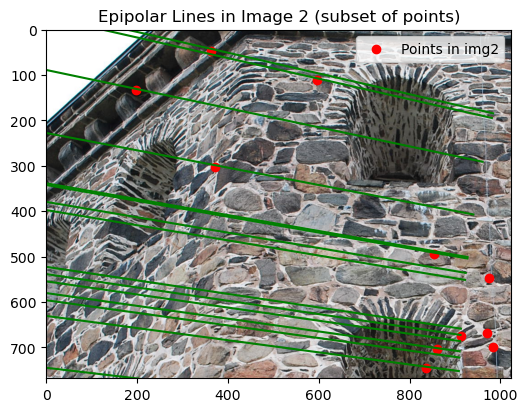

In [46]:
'''
Similar to Computer Exercise 1, compute the fundamental matrix for the un-normalized coordinate
system, using your estimated Essential matrix. Compute the epipolar lines l = Fx1. Pick 20 of the
detected points in the second image at random and plot these in the same figure as the image. Also
plot the corresponding epipolar lines in the same figure using the function rital.m.'''
from rital import rital
# 5) Compute Fundamental matrix for unnormalized coords
#    F = K^-T * E * K^-1
K_inv = inv(K)
F = K_inv.T @ E @ K_inv
print("[INFO] Fundamental matrix F:\n", F)

# Load the second imagea
img2 = cv2.imread("kronan2.jpg")  # Load as BGR (default)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display in Matplotlib

# 6) Plot some epipolar lines in image 2
#    (Pick 20 random points from x1_2D, compute lines in image 2)
n_points = x1.shape[1]
subset_size = min(n_points, 20)
indices = np.random.choice(n_points, size=subset_size, replace=False)

# lines in second image -> l2 = F x1
l2 = F @ x1[:, indices]  # (3, subset_size)


# For demonstration, let's just plot them with random "image size"
plt.figure(figsize=(6,6))

# Plot x2 points for these indices
x2_sel = x2[:, indices]
plt.scatter(x2_sel[0, :], x2_sel[1, :], marker='o', color='red', label='Points in img2')
plt.imshow(img2, cmap='gray')  # Display the image as background

# Epipolar lines
w, h = 1024, 768  # or from an actual image shape
x_vals = np.linspace(0, w, 2)

rital(linjer=l2, st='g-', SCALAR = 1000)

plt.xlim([0, w])
plt.ylim([h, 0])  # typical image coordinates top-left origin
plt.title("Epipolar Lines in Image 2 (subset of points)")
plt.legend()
plt.show()

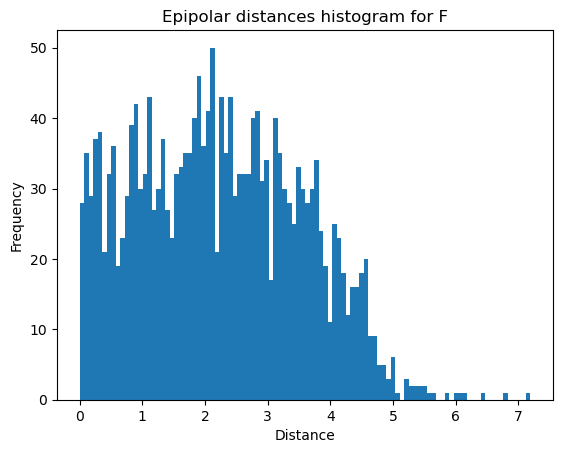

Mean epipolar distance for F_tilde : 2.2342466718494554


In [51]:
# 7) Compute distances from each x2_i to its epipolar line l2_i
#    l2_i = F x1_i for i in [0..N-1]
lines = F @ x1  # shape (3, N)
# Normalize line so sqrt(a^2 + b^2) = 1 => simpler distance formula
a = lines[0,:]
b = lines[1,:]
c = lines[2,:]

# Distances:
x2_inhom = x2[:2,:]/x2[2,:]
distances = np.abs(a*x2_inhom[0,:] + b*x2_inhom[1,:] + c)
mean_dist = np.mean(distances)

plt.figure()
plt.hist(distances, bins=100)
plt.title("Epipolar distances histogram for F")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

print("Mean epipolar distance for x2 to its corresponding epipolar lines is:", mean_dist)